In [5]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api import stream as Stream
from ta.momentum import PercentagePriceOscillator
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from backtesting import Backtest, Strategy
from backtesting.lib import cross, crossover, plot_heatmaps
from ta.trend import SMAIndicator
from ta.volatility import AverageTrueRange, KeltnerChannel
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [16]:
%matplotlib widget

In [6]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

## Setup Data to Train and Validate

In [7]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

### Setup Data Gathering Code

In [8]:
def train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'America/New_York'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index.iloc[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index.iloc[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert('America/New_york')
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert('America/New_york')
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    testval_day = final_df.index[-1] - pd.Timedelta(days= validate_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    testing_df =  final_df.loc[traintest_day:testval_day]
    validate_df = final_df.loc[testval_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, testing_df, validate_df, full_train, offset_df, final_df, traintest_day, testval_day

### Building DataFrame of Code

We will use a stock that has a cyclical nature to train, validate, and then test. 

In [9]:
ticker = "WMT"
interval = "15Min"
train_day_int = 365
test_day_int = 180
val_day_int = 180
offset_day_int = 365
train, test, val, full, offset, complete, traintest_day, testval_day = train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

### Plotting

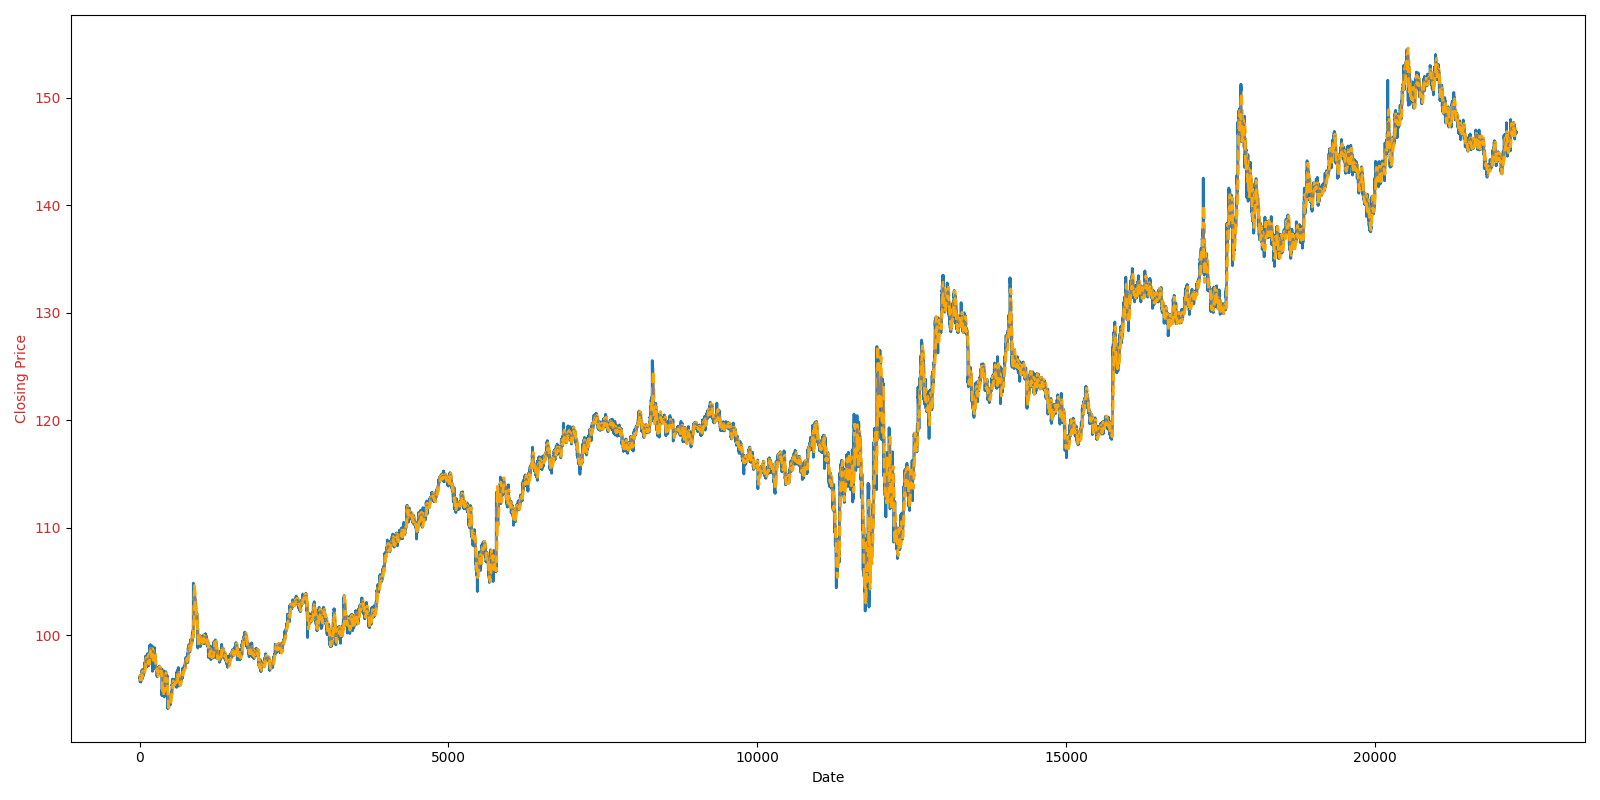

In [10]:
plot_df = full.copy()#[0:800]
plot_df = plot_df.reset_index()
plot_df.set_index("Time")

kc_df = KeltnerChannel(plot_df.High, plot_df.Low, plot_df.Close, window=20,window_atr =10)

fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(plot_df.Close, linewidth = 2, label = 'Close Price')
ax1.plot(kc_df.keltner_channel_hband(), linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
ax1.plot(kc_df.keltner_channel_mband(), linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
ax1.plot(kc_df.keltner_channel_lband(), linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(lband_ind, linewidth = 2, alpha= .25, color = 'green', linestyle = '--', label = 'KC LOWER 20')
# # ax2.plot(hband_ind, linewidth = 2, alpha= .25, color = 'red', linestyle = '--', label = 'KC LOWER 20')
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Adding Indicator Values to Data

In [11]:
def KeltnerIndicators(high, low, close, win, win_atr):
    kc_df = KeltnerChannel(high, low, close, win, win_atr, original_version= False)
    lband_ind = pd.Series(kc_df.keltner_channel_lband_indicator())
    hband_ind = pd.Series(kc_df.keltner_channel_hband_indicator())
    hband = pd.Series(kc_df.keltner_channel_hband())
    mband = pd.Series(kc_df.keltner_channel_mband())
    lband = pd.Series(kc_df.keltner_channel_lband())
    return lband_ind, hband_ind, hband, mband, lband

### Creating Datafrmae and adding indicator details

In [12]:
# Intial Indicator Values
kc_win = 20
kc_win_atr = 5


complete_df = full.copy()
complete_df = complete_df.reset_index()

complete_df["KC_lband_ind"], complete_df["KC_hband_ind"], complete_df["KC_hband"], complete_df["KC_mband"], complete_df["KC_lband"] =  KeltnerIndicators(complete_df.High, complete_df.Low, complete_df.Close, kc_win, kc_win_atr)

#create indicator columns
complete_df["KC_CloseCrossBelow_lband"] = np.where(((complete_df["Close"].shift(1) >= complete_df["KC_lband"].shift(1)) & (complete_df["Close"] < complete_df["KC_lband"])), 1, 0)
complete_df["KC_CloseCrossAbove_lband"] = np.where(((complete_df["Close"].shift(1) <= complete_df["KC_lband"].shift(1)) & (complete_df["Close"] > complete_df["KC_lband"])), 1, 0)
complete_df["KC_CloseCrossBelow_hband"] = np.where(((complete_df["Close"].shift(1) >= complete_df["KC_hband"].shift(1)) & (complete_df["Close"] < complete_df["KC_hband"])), 1, 0)
complete_df["KC_CloseCrossAbove_hband"] = np.where(((complete_df["Close"].shift(1) <= complete_df["KC_hband"].shift(1)) & (complete_df["Close"] > complete_df["KC_hband"])), 1, 0)
complete_df["KC_CloseCrossBelow_mband"] = np.where(((complete_df["Close"].shift(1) >= complete_df["KC_mband"].shift(1)) & (complete_df["Close"] < complete_df["KC_mband"])), 1, 0)
complete_df["KC_CloseCrossAbove_mband"] = np.where(((complete_df["Close"].shift(1) <= complete_df["KC_mband"].shift(1)) & (complete_df["Close"] > complete_df["KC_mband"])), 1, 0)

# create slopes of close and all bands as a way to reference when it may not be following a usual pattern

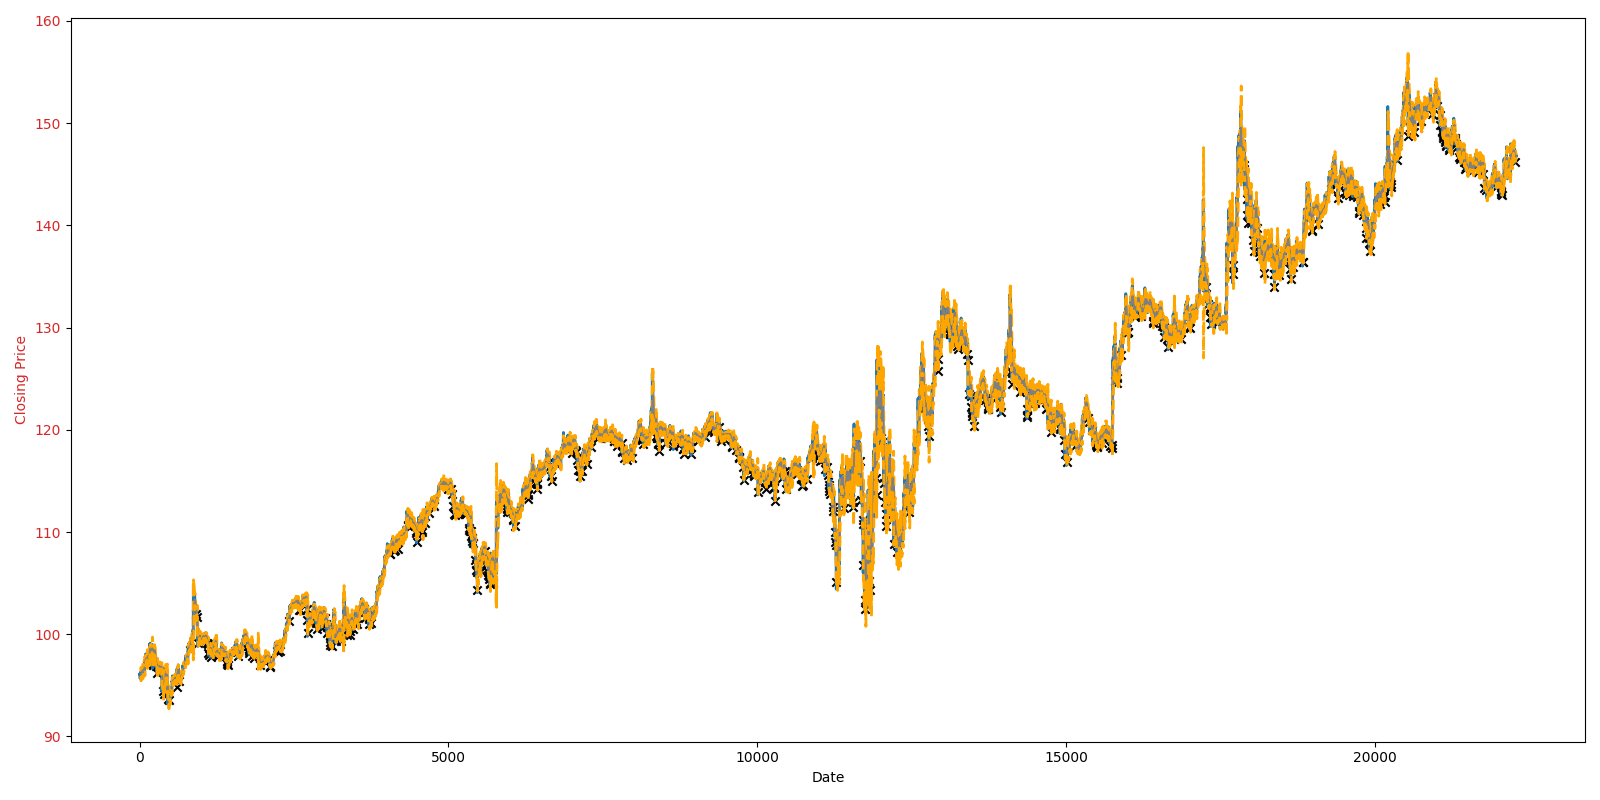

In [17]:
plot_range = complete_df.shape[0]

fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(complete_df.Close, linewidth = 2, label = 'Close Price')
ax1.plot(complete_df.KC_hband, linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
ax1.plot(complete_df.KC_mband, linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
ax1.plot(complete_df.KC_lband, linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
ax1.tick_params(axis='y', labelcolor=color)

for i in range(0,plot_range,1):
    if complete_df.iloc[i]["KC_CloseCrossAbove_lband"] == 1:
        ax1.scatter(i,complete_df.iloc[i]["KC_lband"], color="black", marker='x', label='LBand Cross')
    else:
        pass

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(lband_ind, linewidth = 2, alpha= .25, color = 'green', linestyle = '--', label = 'KC LOWER 20')
# # ax2.plot(hband_ind, linewidth = 2, alpha= .25, color = 'red', linestyle = '--', label = 'KC LOWER 20')
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [14]:
complete_df.iloc[1]["KC_CloseCrossAbove_lband"]

0

In [15]:
complete_df[4400:4440]

,timestamp,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice,KC_lband_ind,KC_hband_ind,KC_hband,KC_mband,KC_lband,KC_CloseCrossBelow_lband,KC_CloseCrossAbove_lband,KC_CloseCrossBelow_hband,KC_CloseCrossAbove_hband,KC_CloseCrossBelow_mband,KC_CloseCrossAbove_mband
4400,2019-06-25 09:15:00-04:00,2019-06-25 09:15:00-04:00,111.0700,111.0700,110.740,110.8100,625,110.936736,1.0,0.0,111.530540,111.208629,110.886718,1,0,0,0,0,0
4401,2019-06-25 09:30:00-04:00,2019-06-25 09:30:00-04:00,110.8800,111.4290,110.560,111.1600,378797,111.101752,0.0,0.0,111.809127,111.203998,110.598869,0,1,0,0,0,0
4402,2019-06-25 09:45:00-04:00,2019-06-25 09:45:00-04:00,111.1600,111.4100,110.940,111.3900,240462,111.222633,0.0,0.0,111.893815,111.221712,110.549609,0,0,0,0,0,1
4403,2019-06-25 10:00:00-04:00,2019-06-25 10:00:00-04:00,111.3900,111.4196,111.100,111.1900,268686,111.316232,0.0,0.0,111.884214,111.218692,110.553170,0,0,0,0,1,0
4404,2019-06-25 10:15:00-04:00,2019-06-25 10:15:00-04:00,111.1900,111.3300,110.965,111.2800,168348,111.189354,0.0,0.0,111.902949,111.224531,110.546113,0,0,0,0,0,1
4405,2019-06-25 10:30:00-04:00,2019-06-25 10:30:00-04:00,111.2800,111.3000,111.065,111.1000,157251,111.185241,0.0,0.0,111.849405,111.212671,110.575937,0,0,0,0,1,0
4406,2019-06-25 10:45:00-04:00,2019-06-25 10:45:00-04:00,111.1050,111.3000,111.050,111.2600,191273,111.189431,0.0,0.0,111.826566,111.217178,110.607791,0,0,0,0,0,1
4407,2019-06-25 11:00:00-04:00,2019-06-25 11:00:00-04:00,111.2500,111.2700,111.120,111.2100,236061,111.209883,0.0,0.0,111.764005,111.216495,110.668985,0,0,0,0,1,0
4408,2019-06-25 11:15:00-04:00,2019-06-25 11:15:00-04:00,111.2200,111.3100,111.170,111.2232,285175,111.222663,0.0,0.0,111.711141,111.217133,110.723125,0,0,0,0,0,1
4409,2019-06-25 11:30:00-04:00,2019-06-25 11:30:00-04:00,111.2300,111.2400,111.090,111.1500,116167,111.154093,0.0,0.0,111.665946,111.210740,110.755533,0,0,0,0,1,0
